# Classification
Classification is about learning how to make predictions from past examples. We are given some examples where we have been told what the correct prediction was, and we want to learn from those examples how to make good predictions in the future.

We will use a form of *supervised learning* to do classification. This means we will have *training data* based on which we will learn a model. We will test its performance on unseen (test) data. Specifically, we will use the k-neareset-neighbor algorithm.

We will work with a dataset collected to help diagnose chronic kidney disease (CKD). Each row represents a patient, for which the diagnosis is known. We also have several measurements for each patiets, based on which we will try to classify future patients as "has CKD" or "doesn't have CKD". Patients with CKD have the label "1" in the "Class" column, while patients who do not have CKD have the label "0". 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = sns.color_palette('viridis', 2)
sns.set_palette(custom_palette)

ckd_df = pd.read_csv('ckd.csv')
display(ckd_df.head())
ckd_df.columns.values

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,1
1,53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,...,29,12100,3.7,yes,yes,no,poor,no,yes,1
2,63,70,1.010,3,0,abnormal,abnormal,present,notpresent,380,...,32,4500,3.8,yes,yes,no,poor,yes,no,1
3,68,80,1.010,3,2,normal,abnormal,present,present,157,...,16,11000,2.6,yes,yes,yes,poor,yes,no,1
4,61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,...,24,9200,3.2,yes,yes,yes,poor,yes,yes,1


array(['Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
       'Red Blood Cells', 'Pus Cell', 'Pus Cell clumps', 'Bacteria',
       'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine', 'Sodium',
       'Potassium', 'Hemoglobin', 'Packed Cell Volume',
       'White Blood Cell Count', 'Red Blood Cell Count', 'Hypertension',
       'Diabetes Mellitus', 'Coronary Artery Disease', 'Appetite',
       'Pedal Edema', 'Anemia', 'Class'], dtype=object)

## Exploring the relationship between different measurements and CKD
We will start by examining the relationship between two variables: Hemoglobin and Glucose, and the presence of CKD. 

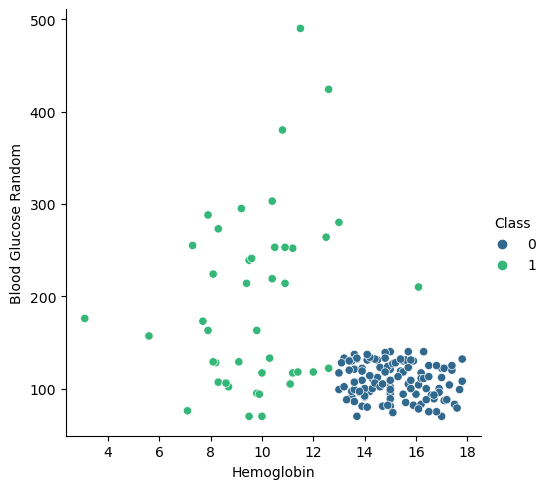

In [2]:
ax = sns.relplot(data=ckd_df, x='Hemoglobin', y='Blood Glucose Random', hue='Class')

Looks like these variables are useful for distinguishing between CKD and non-CKD patients. Note that not all variables will be as indicative. For example, let's look at the white blood cell count and glucose.

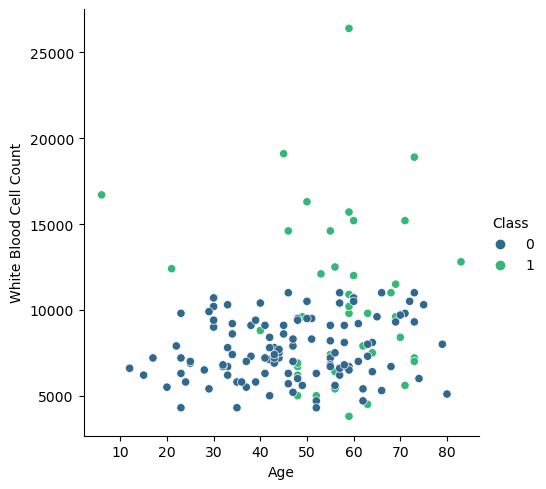

In [3]:
ax = sns.relplot(data=ckd_df, x='Age', y='White Blood Cell Count', hue='Class')

Let's say that Alice is a new patient with Hemoglobin level 14 and Blood Glucose level 240. How can we use the data we have from other patients (our _training data_) to classify Alice to either having or not CKD?

One simple way is to find an observation in the data that is the most similar to Alice, on these two attributes, and then predict that Alice would belong to the same class as the class of that similar observation. The two attributes are numbers so it makes sense to measure "similarity" as a distance.

Our _nearest neighbor classifier_ works like this:
- Find the point in the training data that is nearest to the new point.
- If that nearest point is a "CKD" point, classify the new point as "CKD". If the nearest point is a "not CKD" point, classify the new point as "not CKD".


## 1-Nearest Neighbor
We will now implement a simple 1-NN classifier. 

In [4]:
from scipy.spatial import distance # module for computing distances between vectors

def one_nearest_neighbor_classification(new_obs, df, target_name, predictor_columns):
    min_dist = 1000000 # iniitalize to large number 
    nearest_neighbor = None # the values of the nearest neighbor obs
    min_index = 0 # the index of the nearest neighbor obs
    for index, row in df[predictor_columns].iterrows():
        current_distance = distance.euclidean(np.array(new_obs), np.array(row)) # computes L2 distance
        if current_distance < min_dist:
            nearest_neighbor = row # not actually used here, as we only use its class...
            min_dist = current_distance  
            min_index = index
            
    return df.iloc[min_index][target_name]


In [5]:
alice = np.array([14,240])
predictor_columns = ['Hemoglobin','Blood Glucose Random']
predicted_class = one_nearest_neighbor_classification(alice, ckd_df, 'Class', predictor_columns=predictor_columns)
print('predicted class for Alice is: ', predicted_class)

predicted class for Alice is:  1


Let's plot Alice's data (in red):

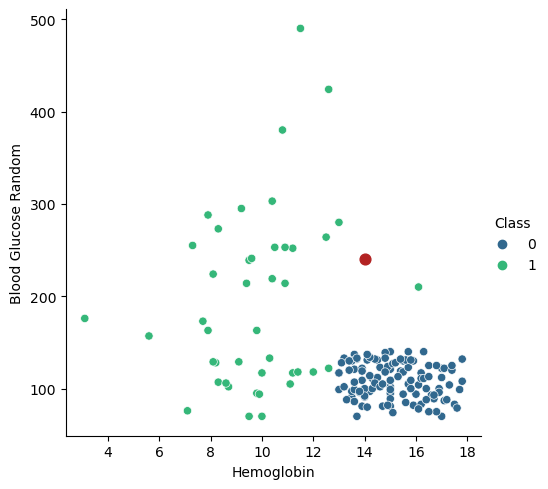

In [6]:
sns.relplot(data=ckd_df, x='Hemoglobin', y='Blood Glucose Random', hue='Class')
plt.scatter(alice[0], alice[1], color='firebrick', s=60)

### Scaling/standardizing variables
A new patient, Bob, with Hemoglobin level 10.5 and Blood Glucose level 90 arrives.
- Look at the scatter plot above: What class do you think Bob will be classified to?
- Now let's run the algorithm and check what 1NN thinks Bob's classification is. 

predicted class for Bob is:  0


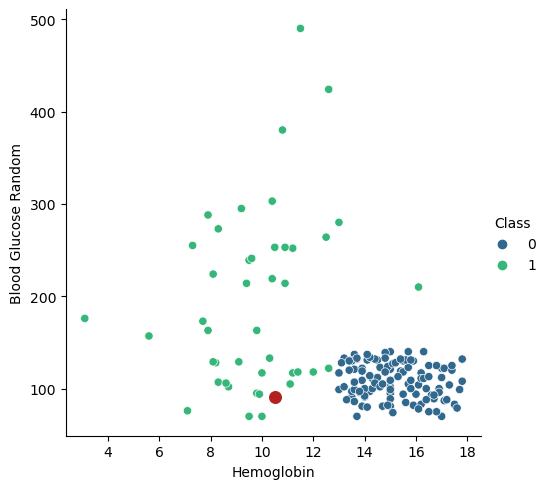

In [7]:
bob = np.array([10.5,91])
predictor_columns = ['Hemoglobin','Blood Glucose Random']
predicted_class = one_nearest_neighbor_classification(bob, ckd_df, 'Class', predictor_columns=predictor_columns)
print('predicted class for Bob is: ', predicted_class)
sns.relplot(data=ckd_df, x='Hemoglobin', y='Blood Glucose Random', hue='Class')
plt.scatter(bob[0], bob[1], color='firebrick', s=70)

What happened? Note that 1NN classifies Bob to the nearest neighbor, where "nearest" is defined by the Euclidean distance. But this distance measure is not invaraint to scale! Although Bob's Hemoglobin suggests he should be classified as hasving CKD ("1"), the distance in Hemoglobin from the nearest training set point that is classified as not having CKD ("0") is just around 2. Yet, in Blood Glucose, there are many points classified as "0" that are close to 90, whereas nearby points classified as "1" have blood glucose of around 100. <br>
That is, just because Blood Glucose is measured on a different scale than Hemoglobin, its contribution to the total Euclidean distance is likely to be much greater. 

#### Decision boundary

Sometimes a helpful way to visualize a classifier is to map out the kinds of attributes where the classifier would predict 'CKD', and the kinds where it would predict 'not CKD'. For example, it will help us discover problems like the one we just had with Bob. We will end up with some boundary between the two classes, where points on one side of the boundary will be classified 'CKD' and points on the other side will be classified 'not CKD'. This boundary is called the decision boundary. Each different classifier will have a different decision boundary; the decision boundary is just a way to visualize what criteria the classifier is using to classify points.

We can do this by using our classifier to classify a wide range of possible observations, varying the values of their predictor features. 

Let's look at an example for the CKD classification, varying the values of Hemoglobin and Glucose, and checking how different points are classified

In [8]:
# # Warning: this code snippet will take a bit of time to run...
# # generate values for points varying hemoglobin and glucose
# # Note, instead of hard-coding, we could've looked at the range between the min and max values in our training data
# hemoglobin_range = np.arange(2,19,0.5)  
# glucose_range = np.arange(40,500,10)

# # plot the training set
# ax = sns.relplot(data=ckd_df, x='Hemoglobin', y='Blood Glucose Random', hue='Class', s=50)

# colors = custom_palette  # define colors for clasees (0-blue, 1-green)

# # find the nearest neighbor for every point in the range, and color it according to 1NN classification
# for x in hemoglobin_range:
#     for y in glucose_range:
#         obs = [x, y]
#         predicted_class = one_nearest_neighbor_classification(obs, ckd_df, 'Class', predictor_columns=predictor_columns)
#         plt.scatter(obs[0], obs[1], color=colors[predicted_class], alpha=0.5, s=9)

Note that some points look weird, such as [6, 140]. Why is the predicted class 0?


### Standardizing variables

If different variables have different scales, their impact on the prediction differs...

A solution to is to standardize units. There are different ways of doing this. One way of to use standard units (also called z-scores):

$x_{normalized} = \frac{x-\overline{X}}{S_{X}}$

Let's normalize the two predictor variables we have been using:

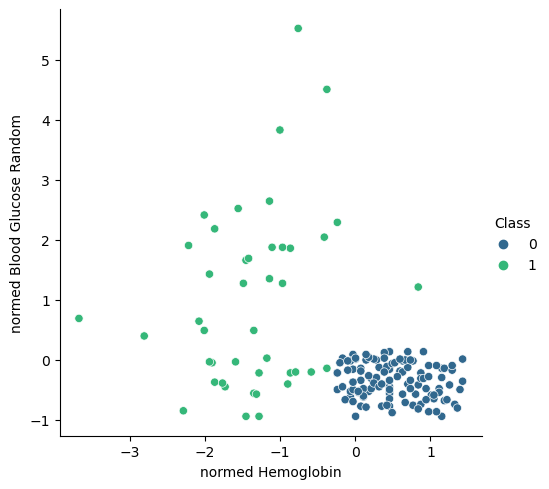

In [9]:
# noramlize the two columns (each according to its values)
ckd_df['normed Hemoglobin'] = ckd_df['Hemoglobin'].apply(lambda x: (x-ckd_df['Hemoglobin'].mean())/ckd_df['Hemoglobin'].std())
ckd_df['normed Blood Glucose Random'] = ckd_df['Blood Glucose Random'].apply(lambda x: (x-ckd_df['Blood Glucose Random'].mean())/ckd_df['Blood Glucose Random'].std())

sns.relplot(data=ckd_df, x='normed Hemoglobin', y='normed Blood Glucose Random', hue='Class')


Note that now the values of the two different variables are on the same scale, so there are no large values that will bias the distance metric.

Now, let's re-examine the prediction of the classifier for Bob and the new decision boundary with our new normalized predictor variables

In [10]:
# # Warning: this code snippet will take a bit of time to run...

# predictor_columns = ['normed Hemoglobin','normed Blood Glucose Random']

# # generate values for points varying hemoglobin and glucose
# hemoglobin_range = np.arange(-4,2,0.15)
# glucose_range = np.arange(-1,6,0.2)

# # plot the training set
# ax = sns.relplot(data=ckd_df, x='normed Hemoglobin', y='normed Blood Glucose Random', hue='Class', s=50)

# colors = custom_palette  # define colors for clasees (0-blue, 1-green)

# # find the nearest neighbor for every point in the range, and color it according to 1NN classification
# for x in hemoglobin_range:
#     for y in glucose_range:
#         obs = [x, y]
#         predicted_class = one_nearest_neighbor_classification(obs, ckd_df, 'Class', predictor_columns=predictor_columns)
#         plt.scatter(obs[0], obs[1], color=colors[predicted_class], alpha=0.5, s=9)

We can see that the decision boundary looks more reasonable now, with no obvious outlier points (either blue or orange). 

We can also check the prediction for Bob now (but we need to use the normalized attributes for Bob as well).

In [11]:
# We need to scale the values of Bob first! 
bob_norm = np.array([(10.5-ckd_df['Hemoglobin'].mean())/ckd_df['Hemoglobin'].std(),
                    (91-ckd_df['Blood Glucose Random'].mean())/ckd_df['Blood Glucose Random'].std()])
predicted_class = one_nearest_neighbor_classification(bob_norm, ckd_df, 'Class', predictor_columns=predictor_columns)
print('predicted class for Bob is: ', predicted_class)

predicted class for Bob is:  1


## Evaluation

How good is our classifier? Did it predict Alice (or Bob) well? Will it predict other future observations well? That is, if a patient has chronic kidney disease, how likely is our classifier to pick that up?

The simple answer is we do not know. Knowing if Alice was classified correctly implies we know the true class of Alice, but then we would not need to predict her class in the first place. The class of Alice is not something we have in the data.

But, we can evaluate our classifier by using data we do have. we will try our classifier on some patients whose true classes are known. Then, we will compute the proportion of the time our classifier was correct. This proportion will serve as an estimate of the proportion of all new patients whose class our classifier will accurately predict. This is called testing.

If we train on all the data we have and then evaluate, we will get 100% accuracy, but this would be fooling ourselves. Instead, we will first split the data to a train set and a test set, and then use only the train set for training, and only the test set for testing. 

One way to make this split, is to randomly shuffle all rows of the dataframe and then take the first _m_ rows to be the train set, and the rest _n_-_m_ rows to be the test set. 

In [12]:
train_size = 126
shuffled_ckd = ckd_df.sample(frac=1)
train_set = shuffled_ckd.iloc[:train_size,:].reset_index() # reset.index is important because we use the index in our 1NN algorithm
test_set = shuffled_ckd.iloc[train_size:,:]
display(train_set)
test_set

,index,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,...,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class,normed Hemoglobin,normed Blood Glucose Random
0,60,48,80,1.025,0,0,normal,normal,notpresent,notpresent,...,4.8,no,no,no,good,no,no,0,0.073783,-0.143853
1,71,33,80,1.025,0,0,normal,normal,notpresent,notpresent,...,6.0,no,no,no,good,no,no,0,1.114653,-0.482628
2,154,42,70,1.025,0,0,normal,normal,notpresent,notpresent,...,6.2,no,no,no,good,no,no,0,0.975871,-0.867600
3,56,45,80,1.020,0,0,normal,normal,notpresent,notpresent,...,5.2,no,no,no,good,no,no,0,0.871784,-0.220847
4,7,73,70,1.005,0,0,normal,normal,notpresent,notpresent,...,3.5,yes,yes,no,good,yes,no,1,-1.279348,-0.944594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,127,68,60,1.025,0,0,normal,normal,notpresent,notpresent,...,6.1,no,no,no,good,no,no,0,1.288132,-0.097656
122,142,57,60,1.020,0,0,normal,normal,notpresent,notpresent,...,4.5,no,no,no,good,no,no,0,0.594218,0.010136
123,152,50,80,1.020,0,0,normal,normal,notpresent,notpresent,...,4.6,no,no,no,good,no,no,0,0.143175,0.087130
124,130,69,70,1.020,0,0,normal,normal,notpresent,notpresent,...,5.4,no,no,no,good,no,no,0,0.871784,-0.744409


,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,...,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class,normed Hemoglobin,normed Blood Glucose Random
147,41,80,1.025,0,0,normal,normal,notpresent,notpresent,112,...,5.8,no,no,no,good,no,no,0,1.149349,-0.297841
54,49,80,1.020,0,0,normal,normal,notpresent,notpresent,122,...,4.9,no,no,no,good,no,no,0,1.149349,-0.143853
14,56,70,1.015,4,1,abnormal,normal,notpresent,notpresent,210,...,5.6,no,no,no,good,no,no,1,0.837088,1.211248
37,64,100,1.015,4,2,abnormal,abnormal,notpresent,present,163,...,3.4,yes,yes,no,good,yes,no,1,-2.007957,0.487501
119,66,70,1.025,0,0,normal,normal,notpresent,notpresent,107,...,4.9,no,no,no,good,no,no,0,-0.030304,-0.374836
0,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,3.9,yes,no,no,poor,yes,yes,1,-0.863000,-0.220847
146,51,80,1.020,0,0,normal,normal,notpresent,notpresent,94,...,6.4,no,no,no,good,no,no,0,0.628914,-0.575021
4,61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,...,3.2,yes,yes,yes,poor,yes,yes,1,-2.077348,0.641490
36,60,90,1.010,3,5,abnormal,normal,notpresent,present,490,...,4.5,yes,yes,no,good,no,no,1,-0.758913,5.522931
73,71,70,1.020,0,0,normal,normal,notpresent,notpresent,81,...,6.0,no,no,no,good,no,no,0,0.351349,-0.775206


In [13]:
# This function checks if the classifier got it right or wrong
def evaluate_one_observation(y_observed, y_predcited):
    if y_observed==y_predcited:
        return 1
    else:
        return 0
    
# This code classifes each observation in the test set and checks if it was correctly classified
n_test = test_set.shape[0]
predictor_columns = ['normed Hemoglobin','normed Blood Glucose Random']
correct_class = np.empty(n_test)
for i in range(n_test):
    obs_to_classify = test_set.iloc[i,:]
    predicted_class = one_nearest_neighbor_classification(obs_to_classify[predictor_columns], train_set, 'Class', predictor_columns)
    correct_class[i] = evaluate_one_observation(obs_to_classify['Class'], predicted_class)
    
display(correct_class)
accuracy = correct_class.mean()
print('Proportion of accurate classifications is', accuracy)

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Proportion of accurate classifications is 0.96875


Nice! Seems like a good classifier. Many times, we will not have such high accuracy. For example, change the predictor features from Hemoglobin to White Blood Cell Count and see what happens.

## *k* Nearest Neighbor classifier

Using only the single nearest neighbor for classification may be too sensitive, as one "outlier" may have a stong effect on predictions. Therefore, typically we will use the top *k* neighbors (more on the choice of *k* later).

We will use an implementation of *k*NN from the sklean library, which provides many tools for machine learning. This makes it very easy for us to change the vaslue of *k*:

In [14]:
# First, define which variables are the features and which are the labels
X = ckd_df.loc[:, predictor_columns].values # features
Y = ckd_df.loc[:, 'Class'].values # labels

# Next, split them to train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

# finally, train a classifier 
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # n_neighbors is the number of neighbors to use for classification
knn_classifier.fit(X_train, Y_train)

# check our predictions!
predictions = knn_classifier.predict(X_test)
print("classifier predictions for test set: \n", predictions)
print("true labels for test set: \n", Y_test, "\n")
print('accuracy of the classifier is', knn_classifier.score(X_test, Y_test))

classifier predictions for test set: 
 [0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1]
true labels for test set: 
 [0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1] 

accuracy of the classifier is 0.96875


We can see that our classifier did pretty well! You can play with the values of k to see how predictions change (note that the test set is selected randomly, so it will run on different points. But you can save it to a variable and re-run the classifier with the same train and test split.

### Encoding categorical variables

How can we compute distance between categorical features? For example, what is the distance between "yes" and "no"?

A common solution is to encode them into numbers. We will use one-hot encoding, which results in equal distance between all possible values (often referred to as "levels") of a categorical variable. This is going to be important when there are more than two possible values.

Here's an example of encoding the categorical "Bacteria" variable in our dataset:

In [15]:
# Get one hot encoding of column Bacteria
variables_to_encode = ['Bacteria']
ckd_df_encoded = pd.get_dummies(ckd_df, columns=variables_to_encode, prefix=variables_to_encode)

display(ckd_df_encoded.head())

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Blood Glucose Random,Blood Urea,...,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class,normed Hemoglobin,normed Blood Glucose Random,Bacteria_notpresent,Bacteria_present
0,48,70,1.005,4,0,normal,abnormal,present,117,56,...,no,no,poor,yes,yes,1,-0.863000,-0.220847,1,0
1,53,90,1.020,2,0,abnormal,abnormal,present,70,107,...,yes,no,poor,no,yes,1,-1.452826,-0.944594,1,0
2,63,70,1.010,3,0,abnormal,abnormal,present,380,60,...,yes,no,poor,yes,no,1,-1.001783,3.829056,1,0
3,68,80,1.010,3,2,normal,abnormal,present,157,90,...,yes,yes,poor,yes,no,1,-2.805957,0.395108,0,1
4,61,80,1.015,2,0,abnormal,abnormal,notpresent,173,148,...,yes,yes,poor,yes,yes,1,-2.077348,0.641490,1,0


### Feature selection

Not all features are good predictors for a given classification problem (as we saw above). We would like to use the features that are useful for distringuishing between the classes, because if we include features that aren't we might add noise to our classifier. 

One simple way to find useful features is examining the correlation of features with our target variable (the class). Features that correlate strongly with the class, whether negatively or positively, can help distinguish between the classes. 

We can visualize correlations using a heatmap.

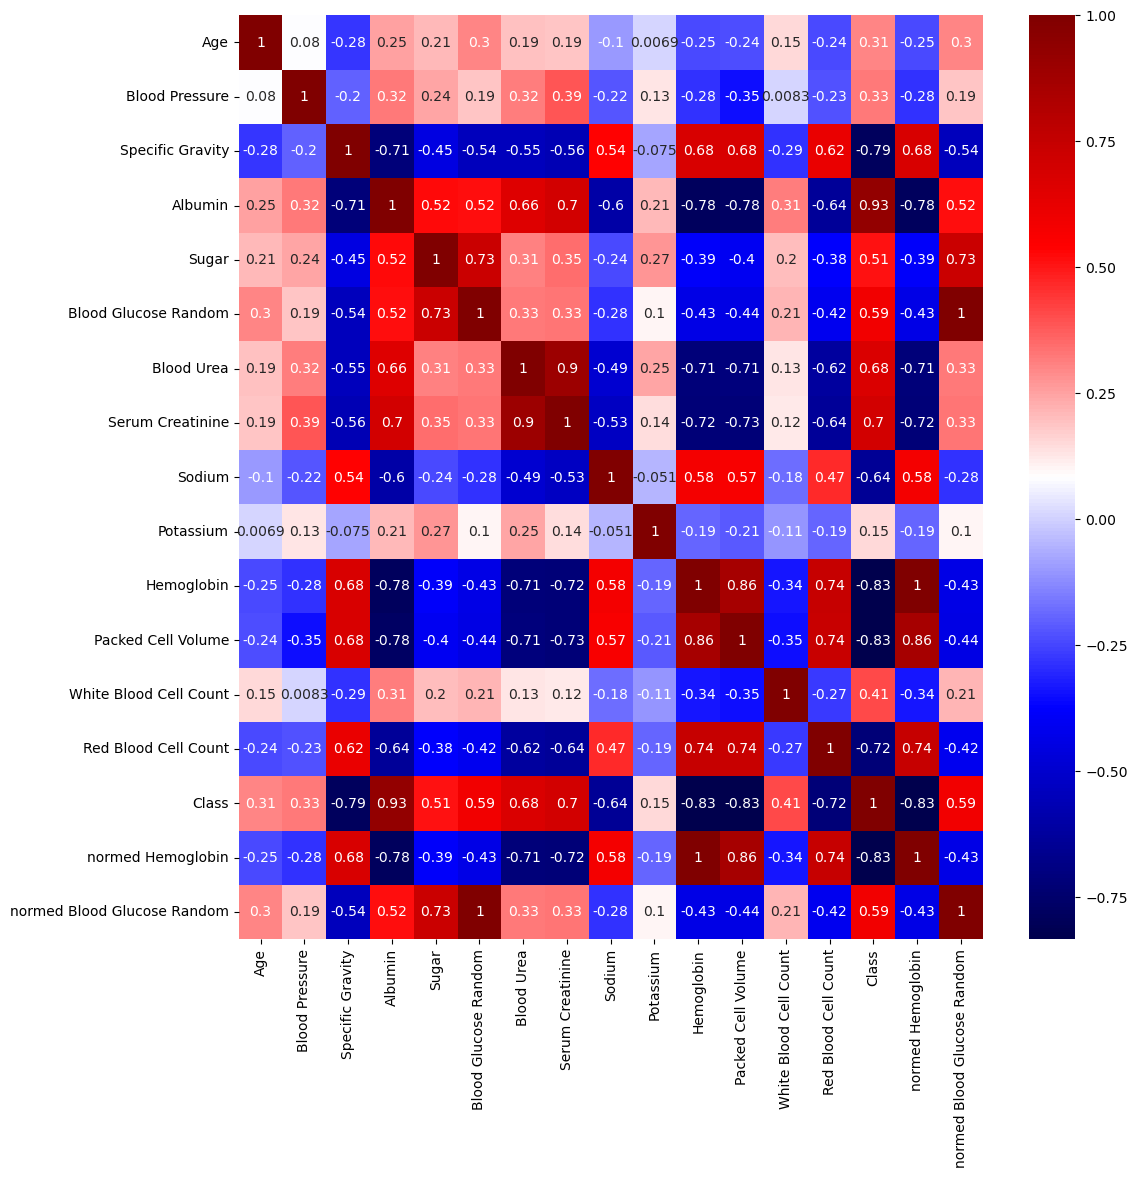

In [16]:
# compute correlation between each pair of variables in data frame
correlations = ckd_df.corr(numeric_only=True)

#plot heat map
plt.figure(figsize=(12,12))
g=sns.heatmap(correlations,annot=True,cmap="seismic")

For example, we can see that Homoglobin, one of the predictor features we used earlier, indeed highly correlates with the class variable (whether the person is sick of not). We can also identify other features that correlate highly with the class, and add them to our classifier

### Breast cancer classification

After taking a biopsy from a lump in the breast, a trained lab technician analyzes the sample to determine whether it is cancer or not. Unfortunately, distinguishing between benign vs malignant can be tricky. 

Researchers use machine learning to help with this task. The idea is that we'll ask the lab tech to analyze the sample and compute various attributes: things like the typical size of a cell, how much variation there is among the cell sizes, and so on. Then, we'll try to use this information to predict (classify) whether the sample is malignant or not. 

We have a training set of past samples from women where the correct diagnosis is known, and we'll hope that our machine learning algorithm can use those to learn how to predict the diagnosis for future samples.

In [17]:
patients_df = pd.read_csv('breast-cancer.csv')
display(patients_df)
patients_df.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2,1,1,1,0
679,2,1,1,1,2,1,1,1,1,0
680,5,10,10,3,7,3,8,10,2,1
681,4,8,6,4,3,4,10,6,1,1


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


**Challenge** (for home):

Try to create a KNN classifier yourself:
- Choose which features to use
- Train a classifier (on a subset of the data)
- Run your predictions (on the reamining data)
- Estimate the accuracy of your classifier
- You can try different predictor features and different values of K (but beware data leakage!)

In [18]:
# your code here